## localizing Robot in 2D

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
class robot:
    def __init__(self, world_size = 100.0, measurement_range = 30.0,
                 motion_noise = 1.0, measurement_noise = 1.0):
        self.world_size = world_size
        self.measurement_range = measurement_range
        self.x = world_size / 2.0
        self.y = world_size / 2.0
        self.motion_noise = motion_noise
        self.measurement_noise = measurement_noise
        self.landmarks = []
        self.num_landmarks = 0

    def rand(self):
        return random.random() * 2.0 - 1.0 
    def move(self, dx, dy):

        x = self.x + dx + self.rand() * self.motion_noise        
        y = self.y + dy + self.rand() * self.motion_noise

        if x < 0.0 or x > self.world_size or y < 0.0 or y > self.world_size:
            return False
        else:
            self.x = x
            self.y = y
            return True
        
    def make_landmarks(self, num_landmarks):
        self.landmarks = []
        for i in range(num_landmarks):
            self.landmarks.append([round(random.random() * self.world_size),
                                   round(random.random() * self.world_size)])
            
        self.num_landmarks = num_landmarks

    def sense(self):
        measurements = []
        for i, (x, y) in enumerate(self.landmarks):
            dx = (x - self.x) + self.rand() * self.measurement_noise
            dy = (y - self.y) + self.rand() * self.measurement_noise
            if (self.measurement_range-abs(dx)) > 0.0 and (self.measurement_range-abs(dy)) > 0.0:
                measurements.append([i, dx, dy])
        return measurements
       
    def __repr__(self):
        return 'Robot: [x=%.5f y=%.5f]'  % (self.x, self.y)

## Define a world and a robot

In [3]:
world_size         = 10.0   
measurement_range  = 5.0     
motion_noise       = 0.2    
measurement_noise  = 0.2  
r = robot(world_size, measurement_range, motion_noise, measurement_noise)

print(r)

Robot: [x=5.00000 y=5.00000]


## Visualizing the World

Robot: [x=5.00000 y=5.00000]


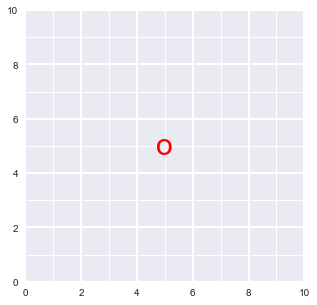

In [4]:
from helpers import display_world

plt.rcParams["figure.figsize"] = (5,5)
print(r)
display_world(int(world_size), [r.x, r.y])

## Movement

Robot: [x=5.81287 y=5.91232]


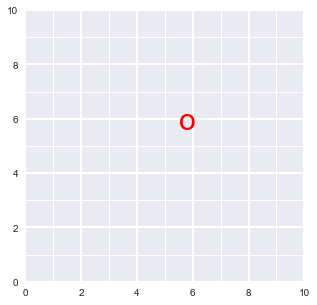

In [5]:
dx = 1
dy = 1
r.move(dx, dy)
print(r)
display_world(int(world_size), [r.x, r.y])

## Landmarks

Robot: [x=5.81287 y=5.91232]


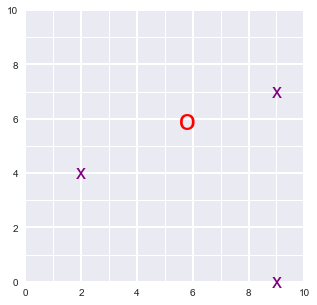

Landmark locations [x,y]:  [[9, 0], [9, 7], [2, 4]]


In [6]:
num_landmarks = 3
r.make_landmarks(num_landmarks)
print(r)
display_world(int(world_size), [r.x, r.y], r.landmarks)
print('Landmark locations [x,y]: ', r.landmarks)

## Create the world for SLAM

In [1]:
import numpy as np
from helpers import make_data

num_landmarks      = 5        
N                  = 20       
world_size         = 100.0    
measurement_range  = 50.0     
motion_noise       = 2.0      
measurement_noise  = 2.0      
distance           = 20.0     
data = make_data(N, num_landmarks, world_size, measurement_range, motion_noise, measurement_noise, distance)

 
Landmarks:  [[91, 62], [46, 16], [68, 75], [9, 18], [66, 27]]
Robot: [x=32.80961 y=49.03172]


In [2]:
time_step = 0
print('Example measurements: \n', data[time_step][0])
print('\n')
print('Example motion: \n', data[time_step][1])

Example measurements: 
 [[0, 41.53984636662785, 10.674076410702602], [1, -2.8391829772621437, -33.60148582500057], [2, 18.680812881578117, 24.991225361731882], [3, -40.919290670797686, -33.537524782760194], [4, 15.853663155297644, -22.68349581984989]]


Example motion: 
 [19.99764853799517, 0.30668053544324747]


## Initialize Constraints

In [3]:
def initialize_constraints(N, num_landmarks, world_size):
    num_constraint= N + num_landmarks
    omega = np.zeros((num_constraint*2, num_constraint*2))
    omega[0][0], omega[1][1] = 1, 1
    xi = np.zeros((num_constraint*2))
    xi[0],xi[1]= world_size/2, world_size/2    
    return omega, xi    

In [5]:
N_test = 5
num_landmarks_test = 2
small_world = 10
initial_omega, initial_xi = initialize_constraints(N_test, num_landmarks_test, small_world)

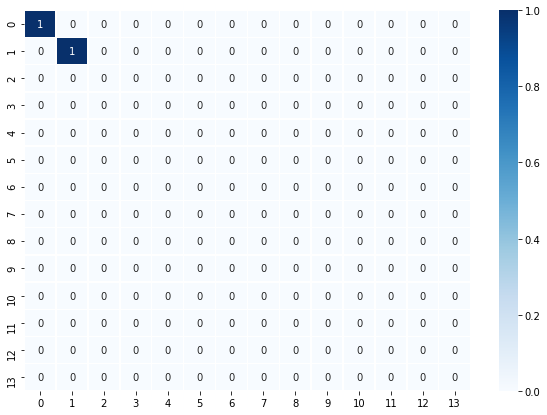

In [7]:
import matplotlib.pyplot as plt
from pandas import DataFrame
import seaborn as sns
%matplotlib inline
sns.heatmap(DataFrame(initial_omega), cmap='Blues', annot=True, linewidths=.5)

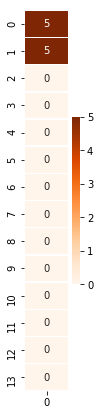

In [8]:
plt.rcParams["figure.figsize"] = (1,7)
sns.heatmap(DataFrame(initial_xi), cmap='Oranges', annot=True, linewidths=.5)

## Implement Graph SLAM with motion and measurements update

In [9]:
def slam(data, N, num_landmarks, world_size, motion_noise, measurement_noise):
    omega, xi = initialize_constraints(N, num_landmarks, world_size)
    alpha, beta = 1/motion_noise, 1/measurement_noise
    
    for i in range(len(data)): #here is 19
        measurements, motion = data[i][0], data[i][1]
        for m in measurements:
            idx_landmark, x,y =m[0], m[1], m[2]
            omega[2*i][2*i] += beta
            omega[2*i][2*N+2*idx_landmark] += -beta
            omega[2*N+2*idx_landmark][2*i] += -beta
            omega[2*N+2*idx_landmark][2*N+2*idx_landmark] += beta
            xi[2*i] += -x*beta
            xi[2*N+2*idx_landmark] += x*beta   
            omega[2*i+1][2*i+1] += beta
            omega[2*i+1][2*N+2*idx_landmark+1] += -beta
            omega[2*N+2*idx_landmark+1][2*i+1] += -beta
            omega[2*N+2*idx_landmark+1][2*N+2*idx_landmark+1] += beta
            xi[2*i+1]+= -y*beta
            xi[2*N+2*idx_landmark+1]+= y*beta   
            
        dx, dy = motion[0], motion[1]
        omega[2*i][2*i] +=alpha
        omega[2*i][2*i+2] +=-alpha
        omega[2*i+2][2*i] +=-alpha
        omega[2*i+2][2*i+2] +=alpha
        xi[2*i] += -dx*alpha
        xi[2*i+2] += dx*alpha
        omega[2*i+1][2*i+1] +=alpha
        omega[2*i+1][2*i+3] +=-alpha
        omega[2*i+3][2*i+1] +=-alpha
        omega[2*i+3][2*i+3] +=alpha
        xi[2*i+1]+= -dy*alpha
        xi[2*i+3]+= dy*alpha

    omega_inv = np.linalg.inv(omega)
    mu = np.dot(omega_inv, xi)
    
    return mu

## Helper functions

In [12]:
def get_poses_landmarks(mu, N):
    poses = []
    for i in range(N):
        poses.append((mu[2*i].item(), mu[2*i+1].item()))

    landmarks = []
    for i in range(num_landmarks):
        landmarks.append((mu[2*(N+i)].item(), mu[2*(N+i)+1].item()))

    return poses, landmarks

In [13]:
def print_all(poses, landmarks):
    print('\n')
    print('Estimated Poses:')
    for i in range(len(poses)):
        print('['+', '.join('%.3f'%p for p in poses[i])+']')
    print('\n')
    print('Estimated Landmarks:')
    for i in range(len(landmarks)):
        print('['+', '.join('%.3f'%l for l in landmarks[i])+']')


## Run SLAM

In [14]:
mu = slam(data, N, num_landmarks, world_size, motion_noise, measurement_noise)

if(mu is not None):
    poses, landmarks = get_poses_landmarks(mu, N)
    print_all(poses, landmarks)



Estimated Poses:
[50.000, 50.000]
[71.685, 49.169]
[93.629, 48.993]
[97.092, 68.959]
[99.484, 87.897]
[81.301, 92.608]
[62.438, 96.397]
[65.495, 76.504]
[68.412, 57.033]
[72.949, 37.475]
[78.012, 18.554]
[81.284, 0.196]
[76.575, 21.506]
[73.234, 40.565]
[68.672, 59.413]
[63.235, 79.726]
[58.857, 98.726]
[49.783, 83.181]
[41.453, 66.845]
[31.643, 49.416]


Estimated Landmarks:
[91.209, 61.664]
[46.138, 15.840]
[68.195, 75.072]
[9.449, 17.822]
[65.637, 26.582]


## Visualize the constructed world

Last pose:  (31.64280790296344, 49.41608356767006)


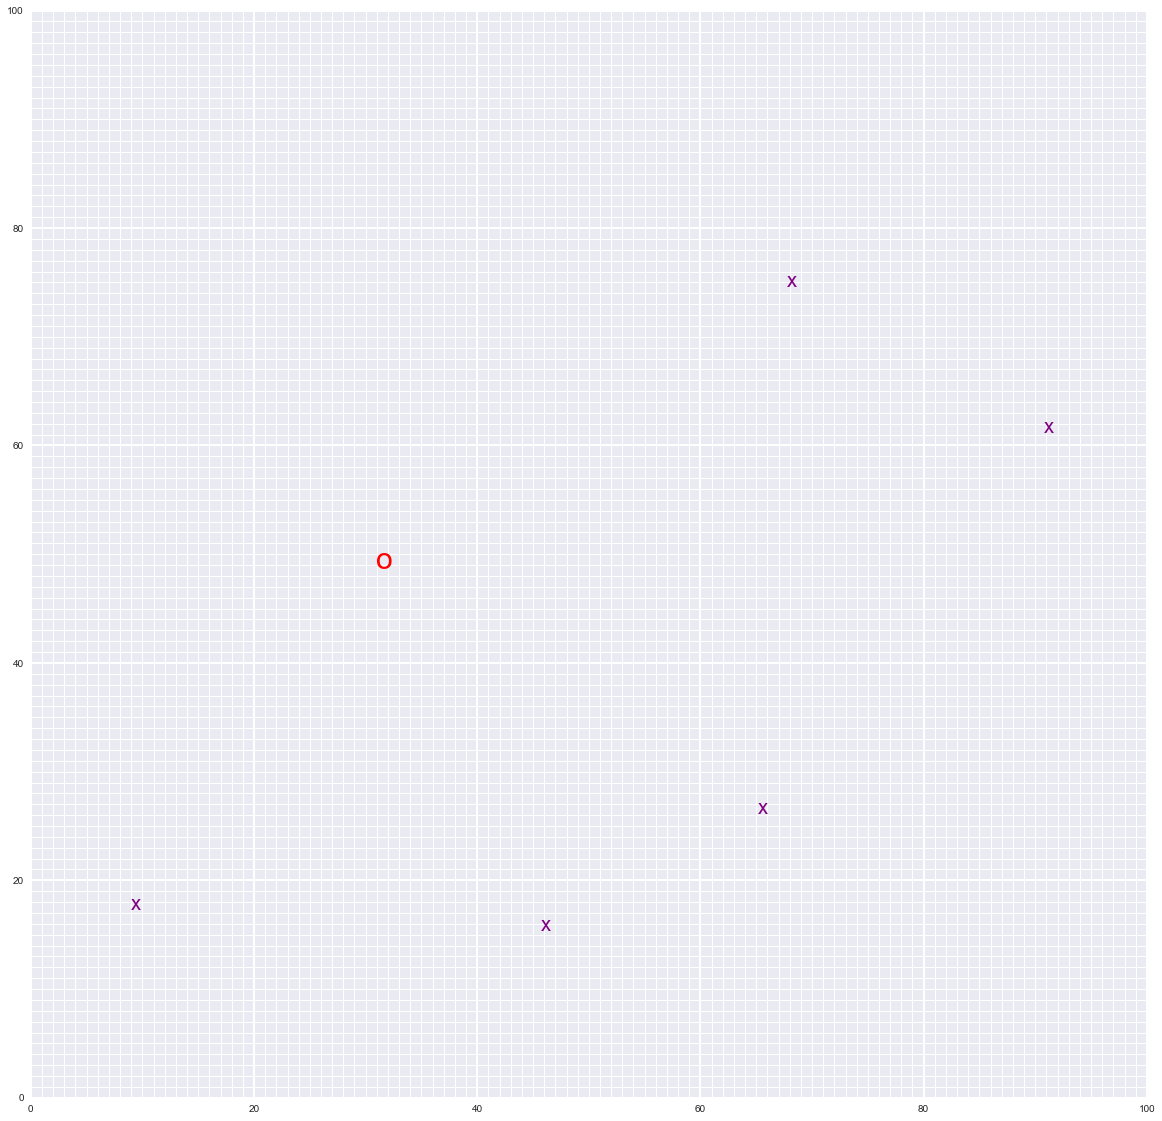

In [15]:
from helpers import display_world
plt.rcParams["figure.figsize"] = (20,20)

if 'poses' in locals():
    print('Last pose: ', poses[-1])
    display_world(int(world_size), poses[-1], landmarks)

## Testing

In [17]:
test_data1 = [[[[1, 19.457599255548065, 23.8387362100849], [2, -13.195807561967236, 11.708840328458608], [3, -30.0954905279171, 15.387879242505843]], [-12.2607279422326, -15.801093326936487]], [[[2, -0.4659930049620491, 28.088559771215664], [4, -17.866382374890936, -16.384904503932]], [-12.2607279422326, -15.801093326936487]], [[[4, -6.202512900833806, -1.823403210274639]], [-12.2607279422326, -15.801093326936487]], [[[4, 7.412136480918645, 15.388585962142429]], [14.008259661173426, 14.274756084260822]], [[[4, -7.526138813444998, -0.4563942429717849]], [14.008259661173426, 14.274756084260822]], [[[2, -6.299793150150058, 29.047830407717623], [4, -21.93551130411791, -13.21956810989039]], [14.008259661173426, 14.274756084260822]], [[[1, 15.796300959032276, 30.65769689694247], [2, -18.64370821983482, 17.380022987031367]], [14.008259661173426, 14.274756084260822]], [[[1, 0.40311325410337906, 14.169429532679855], [2, -35.069349468466235, 2.4945558982439957]], [14.008259661173426, 14.274756084260822]], [[[1, -16.71340983241936, -2.777000269543834]], [-11.006096015782283, 16.699276945166858]], [[[1, -3.611096830835776, -17.954019226763958]], [-19.693482634035977, 3.488085684573048]], [[[1, 18.398273354362416, -22.705102332550947]], [-19.693482634035977, 3.488085684573048]], [[[2, 2.789312482883833, -39.73720193121324]], [12.849049222879723, -15.326510824972983]], [[[1, 21.26897046581808, -10.121029799040915], [2, -11.917698965880655, -23.17711662602097], [3, -31.81167947898398, -16.7985673023331]], [12.849049222879723, -15.326510824972983]], [[[1, 10.48157743234859, 5.692957082575485], [2, -22.31488473554935, -5.389184118551409], [3, -40.81803984305378, -2.4703329790238118]], [12.849049222879723, -15.326510824972983]], [[[0, 10.591050242096598, -39.2051798967113], [1, -3.5675572049297553, 22.849456408289125], [2, -38.39251065320351, 7.288990306029511]], [12.849049222879723, -15.326510824972983]], [[[0, -3.6225556479370766, -25.58006865235512]], [-7.8874682868419965, -18.379005523261092]], [[[0, 1.9784503557879374, -6.5025974151499]], [-7.8874682868419965, -18.379005523261092]], [[[0, 10.050665232782423, 11.026385307998742]], [-17.82919359778298, 9.062000642947142]], [[[0, 26.526838150174818, -0.22563393232425621], [4, -33.70303936886652, 2.880339841013677]], [-17.82919359778298, 9.062000642947142]]]
mu_1 = slam(test_data1, 20, 5, 100.0, 2.0, 2.0)
poses, landmarks = get_poses_landmarks(mu_1, 20)
print_all(poses, landmarks)



Estimated Poses:
[50.000, 50.000]
[37.973, 33.652]
[26.185, 18.155]
[13.745, 2.116]
[28.097, 16.783]
[42.384, 30.902]
[55.831, 44.497]
[70.857, 59.699]
[85.697, 75.543]
[74.011, 92.434]
[53.544, 96.454]
[34.525, 100.080]
[48.623, 83.953]
[60.197, 68.107]
[73.778, 52.935]
[87.132, 38.538]
[80.303, 20.508]
[72.798, 2.945]
[55.245, 13.255]
[37.416, 22.317]


Estimated Landmarks:
[82.956, 13.539]
[70.495, 74.141]
[36.740, 61.281]
[18.698, 66.060]
[20.635, 16.875]


In [18]:
test_data2 = [[[[0, 26.543274387283322, -6.262538160312672], [3, 9.937396825799755, -9.128540360867689]], [18.92765331253674, -6.460955043986683]], [[[0, 7.706544739722961, -3.758467215445748], [1, 17.03954411948937, 31.705489938553438], [3, -11.61731288777497, -6.64964096716416]], [18.92765331253674, -6.460955043986683]], [[[0, -12.35130507136378, 2.585119104239249], [1, -2.563534536165313, 38.22159657838369], [3, -26.961236804740935, -0.4802312626141525]], [-11.167066095509824, 16.592065417497455]], [[[0, 1.4138633151721272, -13.912454837810632], [1, 8.087721200818589, 20.51845934354381], [3, -17.091723454402302, -16.521500551709707], [4, -7.414211721400232, 38.09191602674439]], [-11.167066095509824, 16.592065417497455]], [[[0, 12.886743222179561, -28.703968411636318], [1, 21.660953298391387, 3.4912891084614914], [3, -6.401401414569506, -32.321583037341625], [4, 5.034079343639034, 23.102207946092893]], [-11.167066095509824, 16.592065417497455]], [[[1, 31.126317672358578, -10.036784369535214], [2, -38.70878528420893, 7.4987265861424595], [4, 17.977218575473767, 6.150889254289742]], [-6.595520680493778, -18.88118393939265]], [[[1, 41.82460922922086, 7.847527392202475], [3, 15.711709540417502, -30.34633659912818]], [-6.595520680493778, -18.88118393939265]], [[[0, 40.18454208294434, -6.710999804403755], [3, 23.019508919299156, -10.12110867290604]], [-6.595520680493778, -18.88118393939265]], [[[3, 27.18579315312821, 8.067219022708391]], [-6.595520680493778, -18.88118393939265]], [[], [11.492663265706092, 16.36822198838621]], [[[3, 24.57154567653098, 13.461499960708197]], [11.492663265706092, 16.36822198838621]], [[[0, 31.61945290413707, 0.4272295085799329], [3, 16.97392299158991, -5.274596836133088]], [11.492663265706092, 16.36822198838621]], [[[0, 22.407381798735177, -18.03500068379259], [1, 29.642444125196995, 17.3794951934614], [3, 4.7969752441371645, -21.07505361639969], [4, 14.726069092569372, 32.75999422300078]], [11.492663265706092, 16.36822198838621]], [[[0, 10.705527984670137, -34.589764174299596], [1, 18.58772336795603, -0.20109708164787765], [3, -4.839806195049413, -39.92208742305105], [4, 4.18824810165454, 14.146847823548889]], [11.492663265706092, 16.36822198838621]], [[[1, 5.878492140223764, -19.955352450942357], [4, -7.059505455306587, -0.9740849280550585]], [19.628527845173146, 3.83678180657467]], [[[1, -11.150789592446378, -22.736641053247872], [4, -28.832815721158255, -3.9462962046291388]], [-19.841703647091965, 2.5113335861604362]], [[[1, 8.64427397916182, -20.286336970889053], [4, -5.036917727942285, -6.311739993868336]], [-5.946642674882207, -19.09548221169787]], [[[0, 7.151866679283043, -39.56103232616369], [1, 16.01535401373368, -3.780995345194027], [4, -3.04801331832137, 13.697362774960865]], [-5.946642674882207, -19.09548221169787]], [[[0, 12.872879480504395, -19.707592098123207], [1, 22.236710716903136, 16.331770792606406], [3, -4.841206109583004, -21.24604435851242], [4, 4.27111163223552, 32.25309748614184]], [-5.946642674882207, -19.09548221169787]]] 

mu_2 = slam(test_data2, 20, 5, 100.0, 2.0, 2.0)
poses, landmarks = get_poses_landmarks(mu_2, 20)
print_all(poses, landmarks)



Estimated Poses:
[50.000, 50.000]
[69.181, 45.665]
[87.743, 39.703]
[76.270, 56.311]
[64.317, 72.176]
[52.257, 88.154]
[44.059, 69.401]
[37.002, 49.918]
[30.924, 30.955]
[23.508, 11.419]
[34.180, 27.133]
[44.155, 43.846]
[54.806, 60.920]
[65.698, 78.546]
[77.468, 95.626]
[96.802, 98.821]
[75.957, 99.971]
[70.200, 81.181]
[64.054, 61.723]
[58.107, 42.628]


Estimated Landmarks:
[76.779, 42.887]
[85.065, 77.438]
[13.548, 95.652]
[59.449, 39.595]
[69.263, 94.240]
